In [1]:
import sys

sys.path.append("../")

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from machine_learning.dataset_gen.station_dataframe_generator import StationDataframeGenerator

mpl.rcParams["figure.figsize"] = (8, 6)
mpl.rcParams["axes.grid"] = False


Download example weather data


In [2]:
pm10_data_station_814 = StationDataframeGenerator.generate_station_dataframe(814, range(2019, 2022))
# Beispiel DataFrame
df = pm10_data_station_814.copy()

# Lücken mit bis zu 5 aufeinanderfolgenden NaN-Werten interpolieren
max_gap_size = pd.Timedelta(hours=5)

# Finde die Indizes der NaN-Werte
nan_indices = df[df["pm10"].isnull()].index

# Finde die Lücken mit bis zu 5 aufeinanderfolgenden NaN-Werten
gap_start_indices = []
current_gap_start = None
last_index = None

for index in nan_indices:
    if current_gap_start is None:
        current_gap_start = index
        last_index = index
    elif index - last_index > pd.Timedelta(hours=1):
        if last_index - current_gap_start < max_gap_size:
            gap_start_indices.append([current_gap_start, last_index])
            current_gap_start = index
        else:
            current_gap_start = index

    last_index = index


for start_index, end_index in gap_start_indices:
    length = end_index - start_index
    if length < pd.Timedelta(hours=2):
        length = pd.Timedelta(hours=2)
    real_start = start_index - length
    real_end = end_index + length
    df.loc[real_start:real_end, "pm10"] = df.loc[real_start:real_end, "pm10"].interpolate(method="time")


# Interpoliere die Lücken mit bis zu 5 aufeinanderfolgenden NaN-Werten
for start_index, end_index in gap_start_indices:
    length = end_index - start_index
    if length < pd.Timedelta(hours=2):
        length = pd.Timedelta(hours=2)
    real_start = start_index - length
    real_end = end_index + length
    df.loc[real_start:real_end, "pm10"] = df.loc[real_start:real_end, "pm10"].interpolate(method="time")

df_dropped = df.dropna()
df_dropped


,temperature_2m,relativehumidity_2m,winddirection_10m,windspeed_10m,precipitation,pm10
timestamp,,,,,,
2019-01-01 01:00:00,0.9,83,265,13.7,0.0,84.9443
2019-01-01 02:00:00,0.6,82,257,14.8,0.0,59.5450
2019-01-01 03:00:00,0.3,83,251,15.6,0.0,55.2941
2019-01-01 04:00:00,0.3,85,248,15.2,0.0,39.3113
2019-01-01 05:00:00,0.0,87,237,15.9,0.0,35.3945
...,...,...,...,...,...,...
2021-12-31 20:00:00,9.3,91,260,24.1,0.0,18.2603
2021-12-31 21:00:00,9.6,89,260,23.7,0.0,17.5962
2021-12-31 22:00:00,9.5,87,261,24.1,0.0,17.5859


Feature Engineering

- Time to Sinus/Cosinus


In [3]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
temperature_2m,26304.0,9.791450,8.707957,-18.5,3.0000,9.2000,16.6000,33.800
relativehumidity_2m,26304.0,74.964416,16.904844,22.0,63.0000,79.0000,89.0000,100.000
winddirection_10m,26304.0,210.539462,94.935909,1.0,135.0000,234.0000,287.0000,360.000
windspeed_10m,26304.0,12.667051,6.046212,0.0,8.0000,11.6000,16.3000,46.400
precipitation,26304.0,0.080946,0.336365,0.0,0.0000,0.0000,0.0000,9.200
pm10,25669.0,30.999286,22.603665,2.4,16.7024,24.4351,37.4457,231.934


In [4]:
timestamp_s = df_dropped.index.map(pd.Timestamp.timestamp)

day = 24 * 60 * 60
year = (365.2425) * day

df_dropped["Day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
df_dropped["Day cos"] = np.cos(timestamp_s * (2 * np.pi / day))
df_dropped["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
df_dropped["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))
df_dropped.reset_index(inplace=True)
# df_dropped = df_dropped.drop('time', axis=1)

df_dropped


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

,timestamp,temperature_2m,relativehumidity_2m,winddirection_10m,windspeed_10m,precipitation,pm10,Day sin,Day cos,Year sin,Year cos
0,2019-01-01 01:00:00,0.9,83,265,13.7,0.0,84.9443,2.588190e-01,0.965926,0.002738,0.999996
1,2019-01-01 02:00:00,0.6,82,257,14.8,0.0,59.5450,5.000000e-01,0.866025,0.003455,0.999994
2,2019-01-01 03:00:00,0.3,83,251,15.6,0.0,55.2941,7.071068e-01,0.707107,0.004172,0.999991
3,2019-01-01 04:00:00,0.3,85,248,15.2,0.0,39.3113,8.660254e-01,0.500000,0.004888,0.999988
4,2019-01-01 05:00:00,0.0,87,237,15.9,0.0,35.3945,9.659258e-01,0.258819,0.005605,0.999984
...,...,...,...,...,...,...,...,...,...,...,...
25664,2021-12-31 20:00:00,9.3,91,260,24.1,0.0,18.2603,-8.660254e-01,0.500000,0.003842,0.999993
25665,2021-12-31 21:00:00,9.6,89,260,23.7,0.0,17.5962,-7.071068e-01,0.707107,0.004559,0.999990
25666,2021-12-31 22:00:00,9.5,87,261,24.1,0.0,17.5859,-5.000000e-01,0.866025,0.005275,0.999986
25667,2021-12-31 23:00:00,9.5,85,263,23.9,0.0,15.3053,-2.588190e-01,0.965926,0.005992,0.999982


In [5]:
df = df_dropped.copy()
df


,timestamp,temperature_2m,relativehumidity_2m,winddirection_10m,windspeed_10m,precipitation,pm10,Day sin,Day cos,Year sin,Year cos
0,2019-01-01 01:00:00,0.9,83,265,13.7,0.0,84.9443,2.588190e-01,0.965926,0.002738,0.999996
1,2019-01-01 02:00:00,0.6,82,257,14.8,0.0,59.5450,5.000000e-01,0.866025,0.003455,0.999994
2,2019-01-01 03:00:00,0.3,83,251,15.6,0.0,55.2941,7.071068e-01,0.707107,0.004172,0.999991
3,2019-01-01 04:00:00,0.3,85,248,15.2,0.0,39.3113,8.660254e-01,0.500000,0.004888,0.999988
4,2019-01-01 05:00:00,0.0,87,237,15.9,0.0,35.3945,9.659258e-01,0.258819,0.005605,0.999984
...,...,...,...,...,...,...,...,...,...,...,...
25664,2021-12-31 20:00:00,9.3,91,260,24.1,0.0,18.2603,-8.660254e-01,0.500000,0.003842,0.999993
25665,2021-12-31 21:00:00,9.6,89,260,23.7,0.0,17.5962,-7.071068e-01,0.707107,0.004559,0.999990
25666,2021-12-31 22:00:00,9.5,87,261,24.1,0.0,17.5859,-5.000000e-01,0.866025,0.005275,0.999986
25667,2021-12-31 23:00:00,9.5,85,263,23.9,0.0,15.3053,-2.588190e-01,0.965926,0.005992,0.999982


- convert wind to vector


In [6]:
# Convert to radians.
wd_rad = df.pop("winddirection_10m") * np.pi / 180
df["winddirection_10m"] = wd_rad
df


,timestamp,temperature_2m,relativehumidity_2m,windspeed_10m,precipitation,pm10,Day sin,Day cos,Year sin,Year cos,winddirection_10m
0,2019-01-01 01:00:00,0.9,83,13.7,0.0,84.9443,2.588190e-01,0.965926,0.002738,0.999996,4.625123
1,2019-01-01 02:00:00,0.6,82,14.8,0.0,59.5450,5.000000e-01,0.866025,0.003455,0.999994,4.485496
2,2019-01-01 03:00:00,0.3,83,15.6,0.0,55.2941,7.071068e-01,0.707107,0.004172,0.999991,4.380776
3,2019-01-01 04:00:00,0.3,85,15.2,0.0,39.3113,8.660254e-01,0.500000,0.004888,0.999988,4.328417
4,2019-01-01 05:00:00,0.0,87,15.9,0.0,35.3945,9.659258e-01,0.258819,0.005605,0.999984,4.136430
...,...,...,...,...,...,...,...,...,...,...,...
25664,2021-12-31 20:00:00,9.3,91,24.1,0.0,18.2603,-8.660254e-01,0.500000,0.003842,0.999993,4.537856
25665,2021-12-31 21:00:00,9.6,89,23.7,0.0,17.5962,-7.071068e-01,0.707107,0.004559,0.999990,4.537856
25666,2021-12-31 22:00:00,9.5,87,24.1,0.0,17.5859,-5.000000e-01,0.866025,0.005275,0.999986,4.555309
25667,2021-12-31 23:00:00,9.5,85,23.9,0.0,15.3053,-2.588190e-01,0.965926,0.005992,0.999982,4.590216


Split data into train, validation and test


In [7]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0 : int(n * 0.7)]
val_df = df[int(n * 0.7) : int(n * 0.9)]
test_df = df[int(n * 0.9) :]

num_features = df.shape[1]


Normalization of data


In [90]:
# train_mean = train_df.mean()
# train_std = train_df.std()

# train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std


In [91]:
# df_std = (df - train_mean) / train_std
# df_std = df_std.melt(var_name='Column', value_name='Normalized')
# plt.figure(figsize=(12, 6))
# ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
# _ = ax.set_xticklabels(df.keys(), rotation=90)


Data windowing


In [62]:
class WindowGenerator:
    def __init__(self, input_width, label_width, shift, label_columns=None):
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )


In [69]:
windowGenerator = WindowGenerator(input_width=24 * 7, label_width=24 * 7, shift=24 * 7, label_columns=["value"])


In [70]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    # if self.label_columns is not None:
    #     labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels


WindowGenerator.split_window = split_window


Define plot function


In [80]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go


def plot(self, model=None, plot_col="pm10", max_subplots=3):
    inputs, labels = self.example
    fig = make_subplotss
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    plot_col_index = 4
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n + 1)
        plt.ylabel(f"{plot_col} [normed]")
        plt.plot(self.input_indices, inputs[n, :, plot_col_index], label="Inputs", marker=".", zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        label_col_index = 4

        if label_col_index is None:
            continue

        plt.scatter(
            self.label_indices, labels[n, :, label_col_index], edgecolors="k", label="Labels", c="#2ca02c", s=64
        )
        if model is not None:
            predictions = model(inputs)
            plt.scatter(
                self.label_indices,
                predictions[n, :, label_col_index],
                marker="X",
                edgecolors="k",
                label="Predictions",
                c="#ff7f0e",
                s=64,
            )

        if n == 0:
            plt.legend()

    plt.xlabel("Time [h]")


WindowGenerator.plot = plot


Create Windows


In [20]:
window_size = 14 * 24  # in hours

# find consecutive data (24*14 hours)
windows = []

for index in range(df["pm10"].size - window_size):
    window_begin = df.iloc[index]
    window_end = df.iloc[index + window_size]
    if window_end["timestamp"] - window_begin["timestamp"] == pd.Timedelta(hours=window_size):
        df_copy = df[index : index + (window_size)].copy().drop("timestamp", axis=1)
        windows.append(df_copy)


In [21]:
pd.DataFrame(windows[1])
# len(windows)
# w1.split_window(df)


,temperature_2m,relativehumidity_2m,windspeed_10m,precipitation,pm10,Day sin,Day cos,Year sin,Year cos,winddirection_10m
1,0.6,82,14.8,0.0,59.5450,5.000000e-01,8.660254e-01,0.003455,0.999994,4.485496
2,0.3,83,15.6,0.0,55.2941,7.071068e-01,7.071068e-01,0.004172,0.999991,4.380776
3,0.3,85,15.2,0.0,39.3113,8.660254e-01,5.000000e-01,0.004888,0.999988,4.328417
4,0.0,87,15.9,0.0,35.3945,9.659258e-01,2.588190e-01,0.005605,0.999984,4.136430
5,-0.1,86,17.2,0.0,32.4548,1.000000e+00,7.593439e-12,0.006322,0.999980,4.066617
...,...,...,...,...,...,...,...,...,...,...
332,-2.8,72,25.8,0.0,22.1061,-7.071068e-01,7.071068e-01,0.238392,0.971169,5.288348
333,-3.2,72,24.7,0.0,26.7922,-5.000000e-01,8.660254e-01,0.239088,0.970998,5.218534
334,-3.6,72,23.9,0.0,23.7584,-2.588190e-01,9.659258e-01,0.239784,0.970826,5.113815
335,-3.9,72,21.7,0.0,21.9070,-3.058215e-12,1.000000e+00,0.240480,0.970654,4.974188


In [85]:
window_stack = tf.stack(windows)

windows_shuffled = tf.random.shuffle(window_stack, seed=42)


In [23]:
type(windows_shuffled)
stack = tf.stack(windows_shuffled)

stack.shape


TensorShape([24661, 336, 10])

In [24]:
type(windows_shuffled)


tensorflow.python.framework.ops.EagerTensor

Split windows into train, validation and test


In [86]:
windows_train = windows_shuffled[: int(len(windows_shuffled) * 0.7)]
windows_val = windows_shuffled[int(len(windows_shuffled) * 0.7) : int(len(windows_shuffled) * 0.9)]
widows_test = windows_shuffled[int(len(windows_shuffled) * 0.9) : int(len(windows_shuffled))]


In [32]:
windows_train[0].shape


TensorShape([336, 10])

In [26]:
windowGenerator.split_window(windows_train)


ValueError: Tensor's shape (17262, 0, 10) is not compatible with supplied shape [None, 1, None].

In [48]:
windows_train[:, :168, :].shape


TensorShape([17262, 168, 10])

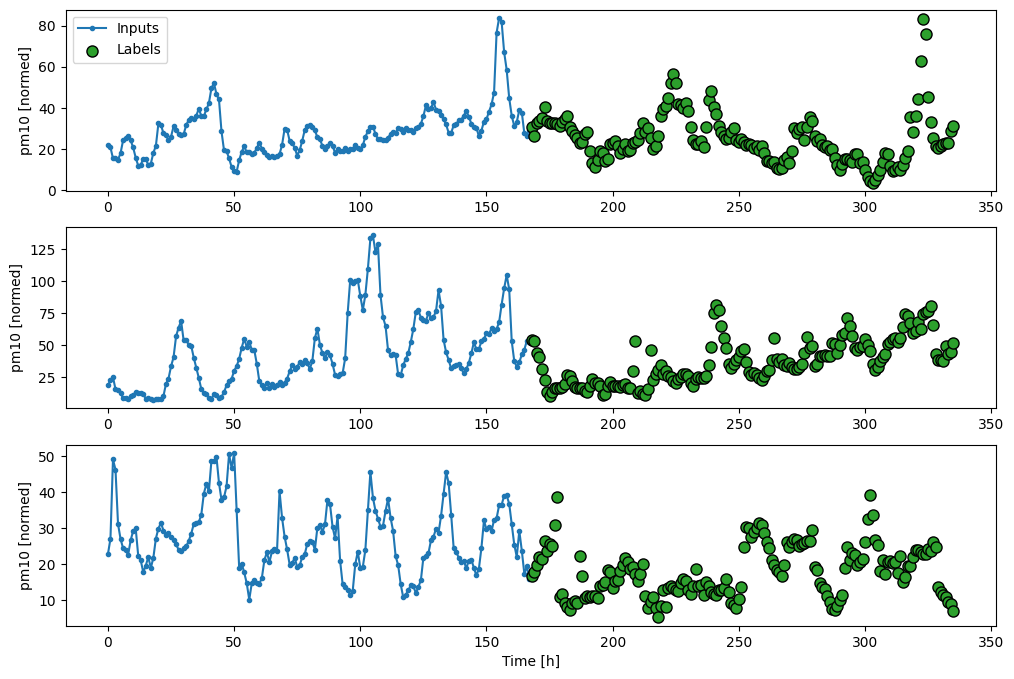

In [89]:
windowGenerator.example = windows_train[:, :168, :], windows_train[:, 168:, :]
windowGenerator.plot()


In [79]:
windowGenerator.example[1][0, :, 4]


<tf.Tensor: shape=(168,), dtype=float64, numpy=
array([18.6355, 20.2639, 19.4751, 26.1629, 24.5132, 20.1915, 25.3533,
       23.8761, 19.4648, 18.556 , 28.0799, 16.2431, 16.8292, 15.2089,
       14.7892, 16.213 , 16.563 , 14.9455, 14.3712, 16.2615, 17.7509,
       24.4752, 27.2149, 24.5478, 19.9224, 18.5587, 18.2432, 21.8649,
       22.4028, 31.5848, 29.3799, 23.772 , 24.8555, 26.6705, 25.9236,
       27.0877, 25.3442, 23.3367, 24.2145, 18.4307, 24.9058, 19.2805,
       18.0813, 19.8272, 19.6014, 19.4558, 21.0851, 22.9488, 22.6784,
       28.3437, 27.5771, 24.1263, 23.1071, 20.5864, 19.4405, 16.3553,
       15.7336, 17.528 , 19.0267, 17.523 , 17.0036, 17.7436, 17.1348,
       16.381 , 16.3455, 15.091 , 14.372 , 15.8322, 35.143 , 36.463 ,
       30.6534, 27.613 , 24.5119, 23.0897, 19.7559, 17.954 , 17.6168,
       18.1835, 20.0944, 18.4225, 15.3539, 13.9831, 20.1817, 18.835 ,
       18.7097, 16.2817, 17.2944, 20.4355, 16.5748, 16.7156, 16.0445,
       16.5648, 15.1894, 13.61  , 13.7222,

Database erstellen


Multi-step model


In [29]:
## 24 Stunden Vorhersage mit 24 Stunden Historie
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS)
multi_window.example = example_inputs, example_labels
multi_window.plot()
multi_window


NameError: name 'example_inputs' is not defined

Definition of the model (Simple single shot network)


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(32, return_sequences=False))
model.add(tf.keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()))
model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))


In [ ]:
CONV_WIDTH = 3
OUT_STEPS = 24 * 14  # 14 days prediction
num_features = 1  # TODO: ??? num_features is 11 but must be one for our prediction

cnn_lstm_model = tf.keras.models.Sequential()
# Shape [batch, time, features] => [batch, CONV_WIDTH, features]
cnn_lstm_model.add(tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]))
# Shape => [batch, 1, conv_units]
cnn_lstm_model.add(tf.keras.layers.Conv1D(256, activation="relu", kernel_size=(CONV_WIDTH)))
cnn_lstm_model.add(tf.keras.layers.MaxPooling1D())
cnn_lstm_model.add(tf.keras.layers.BatchNormalization())  # TODO: useful to put it here?
cnn_lstm_model.add(tf.keras.layers.Conv1D(512, activation="relu", kernel_size=(CONV_WIDTH)))
cnn_lstm_model.add(tf.keras.layers.MaxPooling1D())
cnn_lstm_model.add(tf.keras.layers.BatchNormalization())  # TODO: useful to put it here?
cnn_lstm_model.add(tf.keras.layers.Conv1D(512, activation="relu", kernel_size=(CONV_WIDTH)))

cnn_lstm_model.add(tf.keras.layers.Flatten())
# LSTM
model.add(tf.keras.layers.LSTM(32, return_sequences=False))
model.add(tf.keras.layers.LSTM(32, return_sequences=False))

cnn_lstm_model.add(tf.keras.layers.Dense(512))
cnn_lstm_model.add(tf.keras.layers.Dropout(0.2))
cnn_lstm_model.add(tf.keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()))
# Shape => [batch, out_steps, features] -> for each prediction step one neuron
cnn_lstm_model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))


Compile Method


In [31]:
MAX_EPOCHS = 50
PATIENCE = 10  # for early-stopping; number of epochs where the val_loss must decrease -> otherwise training is stopped

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # for tensorboard


def compile_fit(model, window, patience=PATIENCE):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, mode="min")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), optimizer="Adam", metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )

    return model.fit(
        window.train, epochs=MAX_EPOCHS, validation_data=window.val, callbacks=[early_stopping, tensorboard_callback]
    )
